In [1]:

# Load the saved model
#Modelo_Ciprofloxacin = joblib.load(os.path.join('resultados_Cipro', 'Lasso_Model_Ciprofloxacin.pkl'))
#Modelo_Meropenem = joblib.load(os.path.join('resultados_Merop', 'Lasso_Model_Meropenem.pkl'))



In [1]:
import pandas as pd
import joblib
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
#cardar datos con filtro biologico
#df= pd.read_csv("~/shared/CAMDA2024/Camda24_resistance/DataSets/SelectedVariables/ResistanceGeneCountStrictBiofiltered.tsv.gz", compression="infer", sep='\t')
df= pd.read_csv("~/shared/CAMDA2024/Camda24_resistance/DataSets/ResistanceGeneCountStrict.tsv", sep='\t')

#separar datos a predecir
to_predict = df[df["phenotype"].isna()]

#datos para entrenar
DF_train= df[df["phenotype"].isin(["Resistant", "Susceptible"])]

In [3]:
to_predict

,accession,genus,species,antibiotic,phenotype,measurement_value,3005053,3000830,3003838,3000508,...,3001871,3006268,3005207,3001355,3001117,3001118,3001196,3001090,3001095,3002328
5952,ERR1417717,Escherichia,coli,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5953,ERR1417719,Escherichia,coli,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5954,ERR1417722,Escherichia,coli,ciprofloxacin,NaN,NaN,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5955,ERR1417741,Escherichia,coli,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5956,ERR1417745,Escherichia,coli,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7767,SRR3242343,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7768,SRR2082856,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7769,SRR3242362,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7770,SRR1257300,Salmonella,enterica,ciprofloxacin,NaN,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# OTROS FILTROS

Bacteria = df["genus"].unique()
Bacterias_C = df[df["antibiotic"]=="ciprofloxacin"]["genus"].unique()
Bacterias_M = df[df["antibiotic"]=="meropenem"]["genus"].unique()

df_bacteria = {bacteria: df[df["genus"] == bacteria] for bacteria in Bacteria}
#filtrado por bacteria
to_predict_bacteria = {bacteria: to_predict[to_predict["genus"] == bacteria] for bacteria in Bacteria}

#filtrado por antibiotico
to_predict_Ciprofloxacin = to_predict[to_predict["antibiotic"]=="ciprofloxacin"]
to_predict_Meropenem = to_predict[to_predict["antibiotic"]=="meropenem"]
DF_bacteria = {bacteria: DF_train[DF_train["genus"] == bacteria] for bacteria in Bacteria}

DF_Ciprofloxacin= DF_train[DF_train["antibiotic"]=="ciprofloxacin"]
DF_Meropenem= DF_train[DF_train["antibiotic"]=="meropenem"]

### Funciones

In [5]:
def encode_labels(dataframe):
    """
    Encodes the labels in the specified column of the dataframe.
    
    Parameters:
    - dataframe: The input dataframe.
    
    Returns:
    - encoded_labels: The encoded labels.
    - label_encoder: The label encoder used for encoding.
    """
    labels = dataframe.iloc[:, 4]
    label_encoder = LabelEncoder()
    
    # Fit and transform the labels
    encoded_labels = label_encoder.fit_transform(labels)
    
    return encoded_labels, label_encoder

# Example usage
# Assuming DF is your DataFrame
#encoded_labels, label_encoder = encode_labels(DF)
#print(encoded_labels)


In [6]:
def custom_train_test_split(dataframe, labels, test_size=0.2, random_state=42):
    """
    Splits the dataframe into training and testing sets.
    
    Parameters:
    - dataframe: The input dataframe.
    - labels: The labels to be used for stratification.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.
    
    Returns:
    - X_train, X_test, y_train, y_test: The split datasets.
    """
    stratify_labels = labels
    
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe.iloc[:, 6:],  # Splitting columns from 6 onward
        labels,
        stratify=stratify_labels,
        train_size=1 - test_size,
        random_state=random_state,
        shuffle=True
    )
    
    return X_train, X_test, y_train, y_test

# Example usage:
# DF is your dataframe, and encoded_labels are your encoded labels
#X_train, X_test, y_train, y_test = custom_train_test_split(DF, encoded_labels)


In [7]:
def get_alpha(X_train, y_train, X_test, y_test, cv=10, random_state=42):
    """
    Finds the best alpha for Lasso regression using cross-validation, fits the final model,
    and evaluates the model on both training and testing data.

    Parameters:
    - X_train: Training feature data.
    - y_train: Training target data.
    - X_test: Testing feature data.
    - y_test: Testing target data.
    - cv: Number of cross-validation folds (default is 10).
    - random_state: Random state for reproducibility (default is 42).

    Returns:
    - final_model: The fitted Lasso model with the best alpha.
    - best_alpha: The best alpha value found by LassoCV.
    """
    alphas = np.logspace(-4, 2, 200)

    # Set up the LassoCV model
    lasso_cv = LassoCV(alphas=alphas, cv=cv, random_state=random_state)

    # Fit the model on the training data
    lasso_cv.fit(X_train, y_train)

    # Retrieve the best alpha value
    best_alpha = lasso_cv.alpha_
    print(f"The best alpha value is: {best_alpha}")

    # Train a final Lasso model using the best alpha
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    # Evaluate the model
    training_score = final_model.score(X_train, y_train)
    testing_score = final_model.score(X_test, y_test)
    print(f"Training score: {training_score}")
    print(f"Testing score: {testing_score}")

    return final_model, best_alpha

# Example usage:
# Assuming you have already split your data into X_train, X_test, y_train, and y_test
# final_model, best_alpha = get_alpha(X_train, y_train, X_test, y_test)


In [8]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates the model using the test data and plots the confusion matrix.

    Parameters:
    - model: The trained model.
    - X_test: The test feature data.
    - y_test: The true labels for the test data.
    - threshold: The threshold for converting continuous predictions to binary classes.

    Returns:
    - accuracy: The accuracy of the model.
    - f1: The F1 score of the model.
    - conf_matrix: The confusion matrix.
    """
    # Predict continuous values
    y_pred_continuous = model.predict(X_test)
    
    # Convert continuous predictions to binary classes
    y_pred_binary = (y_pred_continuous >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)  # Convert true values to binary as well
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)#,normalize="true")
    #accuracy = accuracy_score(y_test_binary, y_pred_binary)
    #f1 = f1_score(y_test_binary, y_pred_binary)
    report= classification_report(y_test_binary, y_pred_binary)

    
    # Print the accuracy and F1 score
    #print(f"Accuracy: {accuracy:.2f}")
    #print(f"F1 Score: {f1:.2f}")
    print("resulados del modelo")
    print(f"{report}")

    
    
    
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    class_labels = ["Resistant", "Susceptible"]
    
    # Create a combined annotation with raw numbers and percentages
    annot = np.empty_like(conf_matrix).astype(str)
    nrows, ncols = conf_matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f'{conf_matrix_percent[i, j]:.2f}%'
    
    # Create a new confusion matrix with percentage values
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


    
  
    #return accuracy, f1,  report
    return report,conf_matrix
# Example usage:
# Assuming you have a trained model and test data
# accuracy, f1, conf_matrix = evaluate_model(modelo, X_test, y_test)


In [9]:
def make_predictions_and_save_to_csv(model, to_predict, threshold=0.6):
    """
    Make predictions on the given data using the provided model, 
    and save the predictions to a CSV file.

    Parameters:
    - model: The trained model used for making predictions.
    - to_predict: The DataFrame containing the data to predict on.
    - threshold: The threshold for converting continuous predictions to binary classes.

    Returns:
    - test_predictions_df: A DataFrame containing the predictions.
    """
    # Make predictions
    y_test_pred_continuous = model.predict(to_predict.iloc[:, 6:])
    y_test_pred_binary = (y_test_pred_continuous >= threshold).astype(int)
    
    # Map binary predictions to labels
    Lab_predicted = ['Susceptible' if i == 1 else 'Resistant' for i in y_test_pred_binary]

    # Create a DataFrame with the predictions
    test_predictions_df = pd.DataFrame({
        'genus': to_predict['genus'],
        'species': to_predict['species'],
        'accession': to_predict['accession'],
        'antibiotic': to_predict['antibiotic'],
        'status': Lab_predicted
    })

    return test_predictions_df

# Example usage:
# Assuming you have a trained model `final_model` and data `to_predict`
#predictions_df = make_predictions_and_save_to_csv(final_model, to_predict, threshold=0.5)
#print(predictions_df)

# To save the predictions to a CSV file, you can uncomment the following line
# predictions_df.to_csv("test_predictions.csv", index=False)


In [10]:

#alpha=0.004880251583654434
#final_model = Lasso(alpha=alpha)
#The best alpha value is: 0.0046415888336127815

# Coeficientes del modelo
#df_coeficientes = pd.DataFrame({'predictor': X_train.columns, 'coef': modelo.coef_.flatten()})

# Predictores incluidos en el modelo (coeficiente != 0)
#df_coeficientes[df_coeficientes.coef != 0]

## Todo junto ALV

The best alpha value is: 0.00020022003718155843
Training score: 0.7758593431627465
Testing score: 0.7471540790852327
0.00020022003718155843
resulados del modelo
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       276
           1       0.96      0.97      0.97       915

    accuracy                           0.95      1191
   macro avg       0.93      0.92      0.93      1191
weighted avg       0.95      0.95      0.95      1191



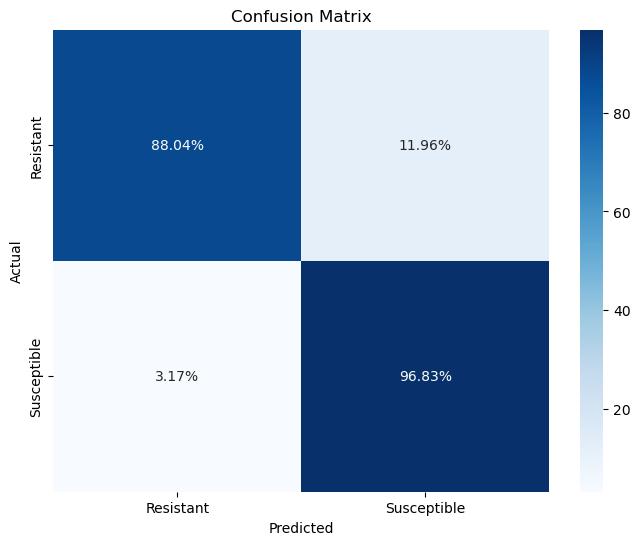

In [11]:
encoded_labels, label_encoder = encode_labels(DF_train)
X_train, X_test, y_train, y_test = custom_train_test_split(DF_train, encoded_labels)
final_model, best_alpha= get_alpha(X_train, y_train, X_test, y_test, cv=10, random_state=42)
print(best_alpha)
#final_model = Lasso(alpha=0.0046415888336127815)
final_model.fit(X_train, y_train)
reporte, conf_matrix = evaluate_model(final_model, X_test, y_test,threshold=.6)
prediction=make_predictions_and_save_to_csv(final_model, to_predict, threshold=0.5)
#save_model(final_model, "Resultados", model_name='Lasso_Model.pkl')

In [12]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': final_model.coef_.flatten()}
                  )
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,3005053,0.054160
4,3003890,0.097792
6,3000833,0.057208
7,3000832,0.008176
13,3000656,0.021031
...,...,...
775,3006241,0.258645
781,3002680,-0.117861
785,3001678,-0.041156
795,3001080,0.023967


In [13]:
#TD["MIC"]=np.zeros(1820)

#TD["status"]=Lab_predicted

#TD.to_csv(os.path.join("Resultados_Lasso", "TestDataset" + "_phenotype_predicted.csv"), index=False)

In [14]:
#prediction.to_csv(os.path.join("Resultados_Lasso", "All_Lasso" + "_test_predictions.csv"), index=False)

## Ciprofloxacin

The best alpha value is: 0.00021461411978584036
Training score: 0.9480810915214374
Testing score: 0.9000690273718129
0.00021461411978584036
resulados del modelo
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       1.00      1.00      1.00       522

    accuracy                           0.99       564
   macro avg       0.99      0.98      0.98       564
weighted avg       0.99      0.99      0.99       564



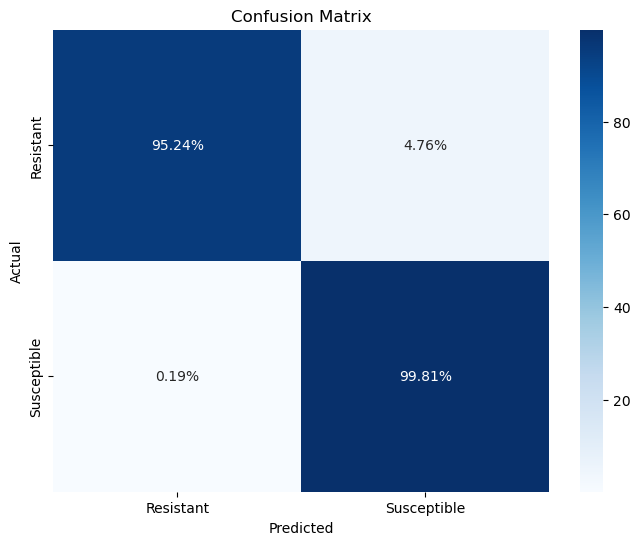

,predictor,coef
22,3000165,6.254536e-03
25,3000412,-6.835288e-03
55,3003308,-6.764881e-01
71,3000873,-4.721311e-03
73,3001878,-1.288654e-01
77,3003369,9.678995e-04
84,3003479,3.662511e-05
85,3000166,5.214142e-05
93,3002683,-7.541737e-04
97,3003923,-5.971879e-01


In [15]:
encoded_labels, label_encoder = encode_labels(DF_Ciprofloxacin)
X_train, X_test, y_train, y_test = custom_train_test_split(DF_Ciprofloxacin, encoded_labels)
final_model, best_alpha= get_alpha(X_train, y_train, X_test, y_test, cv=10, random_state=42)
print(best_alpha)
#final_model = Lasso(alpha=0.0046415888336127815)
final_model.fit(X_train, y_train)
reporte, conf_matrix = evaluate_model(final_model, X_test, y_test)
prediction=make_predictions_and_save_to_csv(final_model, to_predict, threshold=0.5)

#my_prediction_C = predict_labels(modelo, to_predict_Ciprofloxacin)
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': final_model.coef_.flatten()}
                  )
df_coeficientes[df_coeficientes.coef != 0]

## Meropenem

The best alpha value is: 0.00040088063288984643
Training score: 0.7088352560098434
Testing score: 0.6164229900075462
resulados del modelo
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       233
           1       0.90      0.93      0.91       394

    accuracy                           0.89       627
   macro avg       0.88      0.87      0.88       627
weighted avg       0.89      0.89      0.89       627



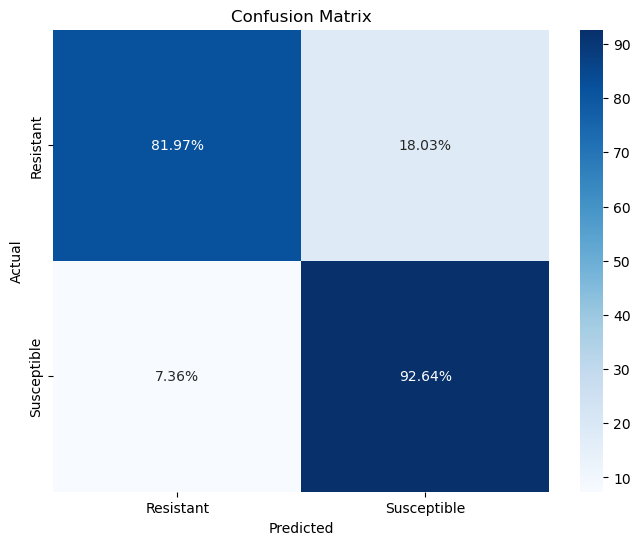

,predictor,coef
4,3003890,0.111782
6,3000833,0.126939
7,3000832,0.040094
13,3000656,0.012797
15,3004039,-0.005870
...,...,...
711,3001619,0.279388
781,3002680,-0.080892
785,3001678,-0.079606
795,3001080,0.003798


In [16]:
encoded_labels, label_encoder = encode_labels(DF_Meropenem)
X_train, X_test, y_train, y_test = custom_train_test_split(DF_Meropenem, encoded_labels)
final_model, best_alpha = get_alpha(X_train, y_train, X_test, y_test)
final_model.fit(X_train, y_train)
resumen, conf_matrix = evaluate_model(final_model, X_test, y_test,threshold=.6)
prediction=make_predictions_and_save_to_csv(final_model, to_predict, threshold=0.5)

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': final_model.coef_.flatten()}
                  )
df_coeficientes[df_coeficientes.coef != 0]

## Por bacteria

Start with Acinetobacter:
resulados del modelo
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.94      1.00      0.97        29

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



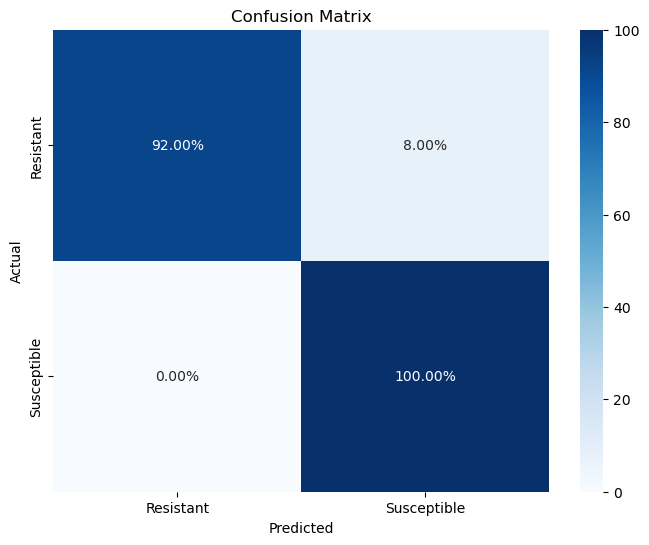

Start with Campylobacter:
resulados del modelo
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.97      1.00      0.99        77

    accuracy                           0.98        95
   macro avg       0.99      0.94      0.96        95
weighted avg       0.98      0.98      0.98        95



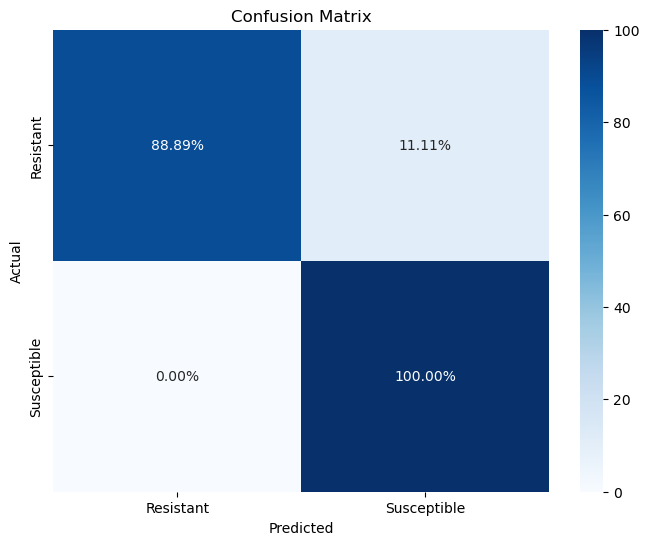

Start with Enterobacter:
resulados del modelo
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.73      1.00      0.84         8

    accuracy                           0.79        14
   macro avg       0.86      0.75      0.75        14
weighted avg       0.84      0.79      0.77        14



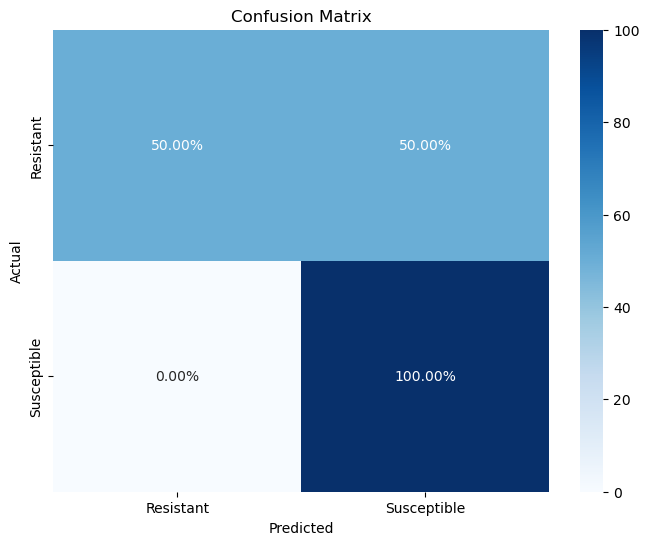

Start with Escherichia:
resulados del modelo
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.94      0.98      0.96        47

    accuracy                           0.92        53
   macro avg       0.84      0.74      0.78        53
weighted avg       0.92      0.92      0.92        53



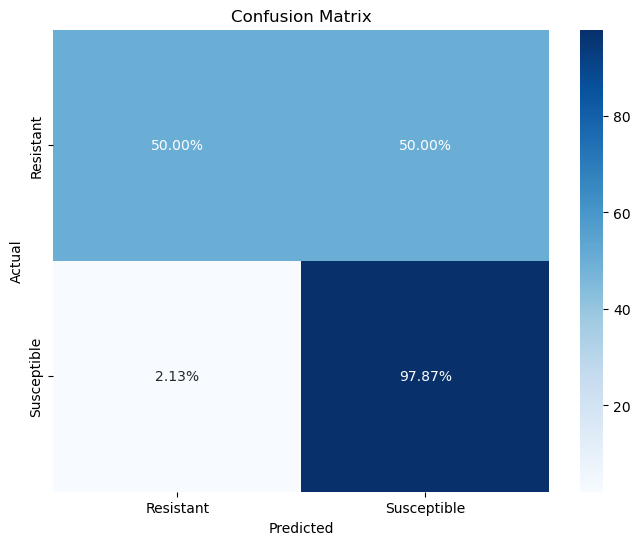

Start with Klebsiella:
resulados del modelo
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       143
           1       0.92      0.97      0.95       257

    accuracy                           0.93       400
   macro avg       0.93      0.91      0.92       400
weighted avg       0.93      0.93      0.93       400



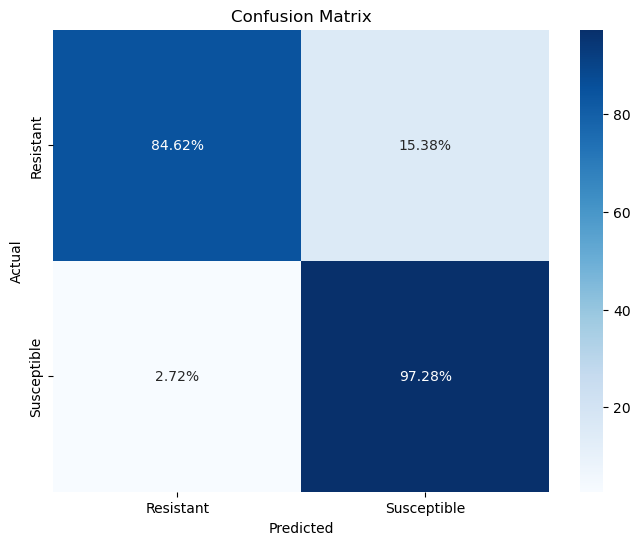

Start with Neisseria:
resulados del modelo
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        14

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



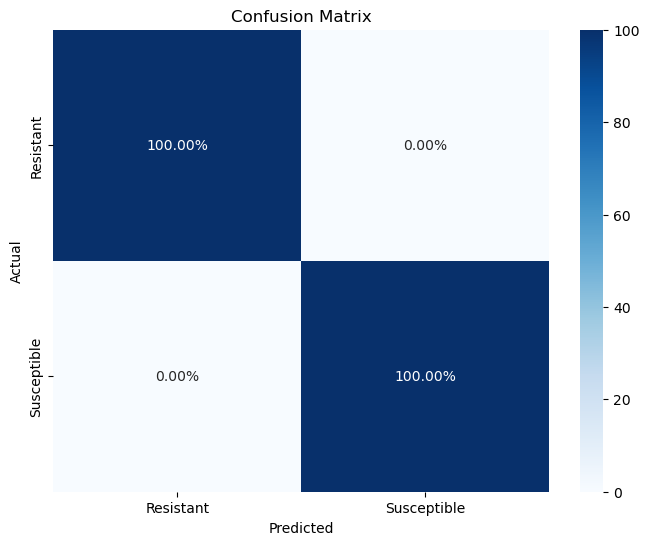

Start with Pseudomonas:
resulados del modelo
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        53
           1       0.70      0.80      0.75        55

    accuracy                           0.72       108
   macro avg       0.73      0.72      0.72       108
weighted avg       0.73      0.72      0.72       108



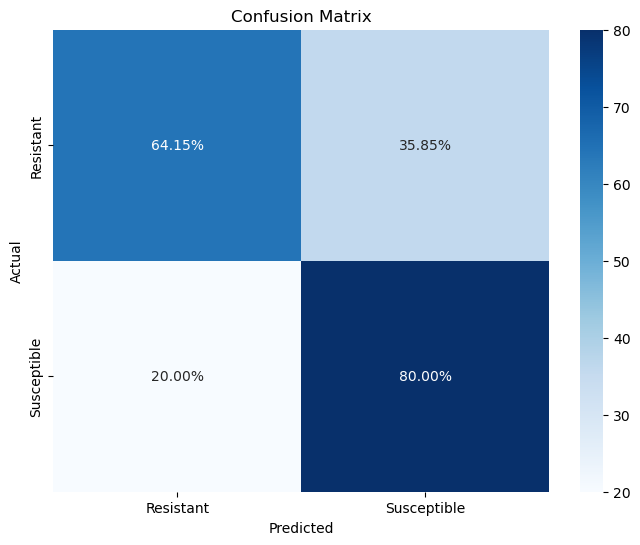

Start with Salmonella:
resulados del modelo
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00       431

    accuracy                           1.00       433
   macro avg       1.00      0.75      0.83       433
weighted avg       1.00      1.00      1.00       433



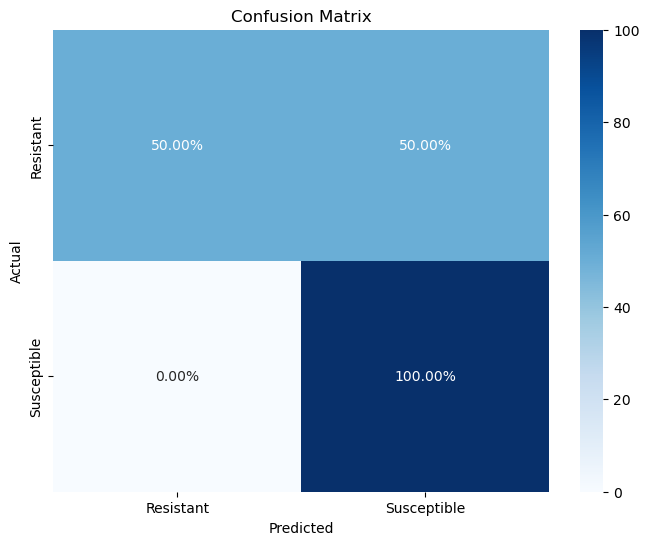

In [17]:
for bacteria in Bacteria:
    print(f"Start with {bacteria}:")
    
    encoded_labels, label_encoder = encode_labels(DF_bacteria[bacteria])
    X_train, X_test, y_train, y_test = custom_train_test_split(DF_bacteria[bacteria], encoded_labels)
    
    final_model.fit(X_train, y_train)
    resumen, conf_matrix = evaluate_model(final_model, X_test, y_test,threshold=.43)

## Todo junto ALV con variables categoricas

The best alpha value is: 0.00020022003718155843
Training score: 0.7759954344934488
Testing score: 0.7470792657870724
resulados del modelo
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       276
           1       0.95      0.98      0.96       915

    accuracy                           0.94      1191
   macro avg       0.94      0.90      0.92      1191
weighted avg       0.94      0.94      0.94      1191



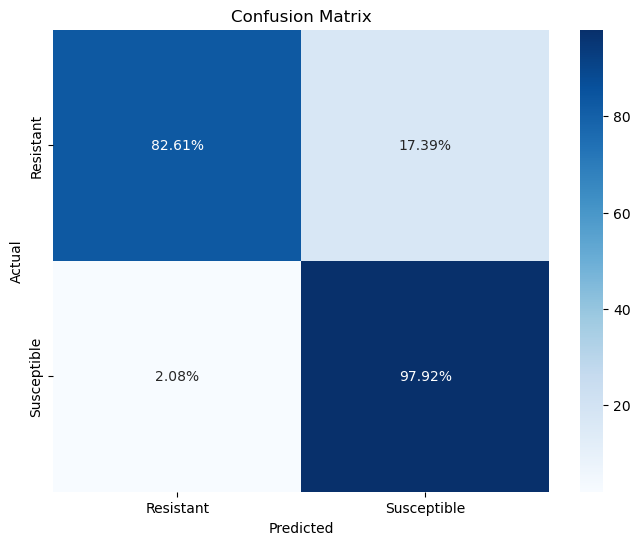

In [18]:
DF_train= df[df["phenotype"].isin(["Resistant", "Susceptible"])]

col_1 = DF_train.iloc[:,1]
col_2 = DF_train.iloc[:,2]
col_3 = DF_train.iloc[:,3]
col_5 = DF_train.iloc[:,5]
label_encoder = LabelEncoder()
    
    # Fit and transform the labels
col_1_encoder = label_encoder.fit_transform(col_1)
col_2_encoder = label_encoder.fit_transform(col_2)
col_3_encoder = label_encoder.fit_transform(col_3)
col_5_encoder = label_encoder.fit_transform(col_5)

DF_train_cat = DF_train
DF_train_cat["genus"]=col_1_encoder
DF_train_cat["species"]=col_2_encoder
DF_train_cat["antibiotic"]=col_3_encoder

#DF_train_cat["measurement_value"]=col_5_encoder

exclude_indices = [0,4,5]
# Get column names
exclude_columns = DF_train_cat.columns[exclude_indices]


encoded_labels, label_encoder = encode_labels(DF_train_cat)
DF_train_cat= DF_train_cat.drop(columns=exclude_columns)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    DF_train_cat,
    encoded_labels, 
    stratify=encoded_labels, 
    train_size=0.8,
    random_state=42, 
    shuffle=True
)


final_model, best_alpha = get_alpha(X_train, y_train, X_test, y_test)
final_model.fit(X_train, y_train)
resumen, conf_matrix = evaluate_model(final_model, X_test, y_test)
#prediction=make_predictions_and_save_to_csv(final_model, to_predict, threshold=0.5)

## Metamos el pangenoma

In [13]:
pip install polars

  Using cached polars-0.20.31-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
Using cached polars-0.20.31-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (28.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
import polars as pl
#Pangenomas
df_polar_M= pl.read_csv("~/shared/CAMDA2024/Camda24_resistance/DataSets/PangenomeCountMeropenem.tsv", separator="\t")

df_M = df_polar_M.to_pandas()

In [15]:
to_predict_pan_M = df_M[df_M["phenotype"].isna()]

#datos para entrenar
DF_train_pan_M= df_M[df_M["phenotype"].isin(["Resistant", "Susceptible"])]

In [16]:
encoded_labels_M, label_encoder_M = encode_labels(DF_train_pan_M)
X_train_M, X_test_M, y_train_M, y_test_M = custom_train_test_split(DF_train_pan_M, encoded_labels_M)
final_model = Lasso(alpha= 0.00020022003718155843)
#final_model_M, best_alpha_M= get_alpha(X_train_M, y_train_M, X_test_M, y_test_M, cv=10, random_state=42)
print(best_alpha_M)
#final_model = Lasso(alpha=0.0046415888336127815)
final_model_M.fit(X_train_M, y_train_M)
reporte_M, conf_matrix_M = evaluate_model(final_model_M, X_test_M, y_test_M,threshold=.6)
#prediction_M=make_predictions_and_save_to_csv(final_model, to_predict, threshold=0.5)
#save_model(final_model, "Resultados", model_name='Lasso_Model.pkl')

NameError: name 'best_alpha_M' is not defined